## Physics Informed Neural Networks to Approximate Solution of PDEs

In [10]:
from google.colab import drive

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [12]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, regularization_param, regularization_exp, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss


def fit(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. below
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p) + model.regularization()
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        if verbose: print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history

Consider the one-dimensional heat equation:

$$
u_t(t, x) = u_{xx}(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$


with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0,
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

We want to obtain an approximate solution of the heat equation $u : [0,T]\times[-1,1] \mapsto \mathbb{R}$ with physics informed neural networks (PINNs).

To do so, we approximate the underlying solution with a feedforward dense neural network with tunable parameters $\theta$:

$$
u_\theta(t,x) \approx u(t,x)
$$
Define the following residuals:

   - Interior residual given by,

   $$r_{int,\theta}(t, x):=  u_{\theta, t}(x,t) - u_{\theta, xx}(x,t), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
   
        
      
        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta) = \int_{[0,T]\times[-1,1]}r_{int,\theta}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences.

$$
L_{int}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

and solve the following minimization problem

$$
\theta^\ast = argmin_{\theta} \Big(L_{int}(\theta) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta)
$$



In [13]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 0.1],  # Time dimension
                                            [-1, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(
                                              input_dimension=self.domain_extrema.shape[0],
                                              output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, x):
        # TODO: Return the initial condition u(x, 0)
        # Hint: use torch.sin and np.pi
        return -torch.sin(np.pi * x)

    # Exact solution: u(t, x) = -exp(-pi^2 * t) * sin(pi * x)
    def exact_solution(self, inputs):
        # TODO: Return exact solution for given inputs (t, x)
        # Hint: extract t = inputs[:, 0], x = inputs[:, 1]
        return -torch.exp(-np.pi ** 2 * inputs[:, 0]) * torch.sin(np.pi * inputs[:, 1])

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        # TODO: Sample n_tb points in the domain, set t = 0, output = u0(x)
        # Steps:
        # 1) Draw samples with Sobol → convert to domain
        # 2) Replace t-column with zeros
        # 3) Evaluate initial condition
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = torch.tensor(self.initial_condition(input_tb))

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        # TODO: Sample n_sb points in the domain, clone two copies for x = -1 and x = 1
        # Outputs should be zeros (Dirichlet BC)
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat((input_sb_0, input_sb_L), 0), torch.cat((output_sb_0, output_sb_L), 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))

        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)

        return u_pred_sb

    # Function to compute the PDE residuals
    # Compute PDE residual r = u_t - u_xx
    def compute_pde_residual(self, input_int):
        # TODO: Compute residual at interior points

        # Steps:
        # 1) Set requires_grad = True
        # 2) Compute u = NN(input_int)
        # 3) Compute gradient w.r.t inputs → grad_u = [u_t, u_x]
        # 4) Compute second derivative u_xx
        # 5) Return r = u_t - u_xx
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)

        ## hint
        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2], [dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        u_grad = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        u_grad_t = u_grad[:,0]
        u_grad_x = u_grad[:,1]
        u_grad_xx = torch.autograd.grad(u_grad_x.sum(), input_int, create_graph=True)[0][:,1]

        return (u_grad_t - u_grad_xx).reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        # TODO: Compute boundary losses and PDE loss
        # Steps:
        # 1) Predict u on SB and TB
        # 2) Compute residuals: r_sb = u_true - u_pred, etc.
        # 3) Compute MSE for each term
        # 4) Combine: loss = log10(lambda_u*(loss_sb+loss_tb) + loss_int)
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        return torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs).reshape(-1, )
        exact_output = self.exact_solution(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Solution")
        axs[1].set_title("Approximate Solution")

        plt.show()

        err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
        print("L2 Relative Error Norm: ", err.item(), "%")


In [14]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

/tmp/ipython-input-4165451285.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_tb = torch.tensor(self.initial_condition(input_tb))


/tmp/ipython-input-4165451285.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_tb = torch.tensor(self.initial_condition(input_tb))


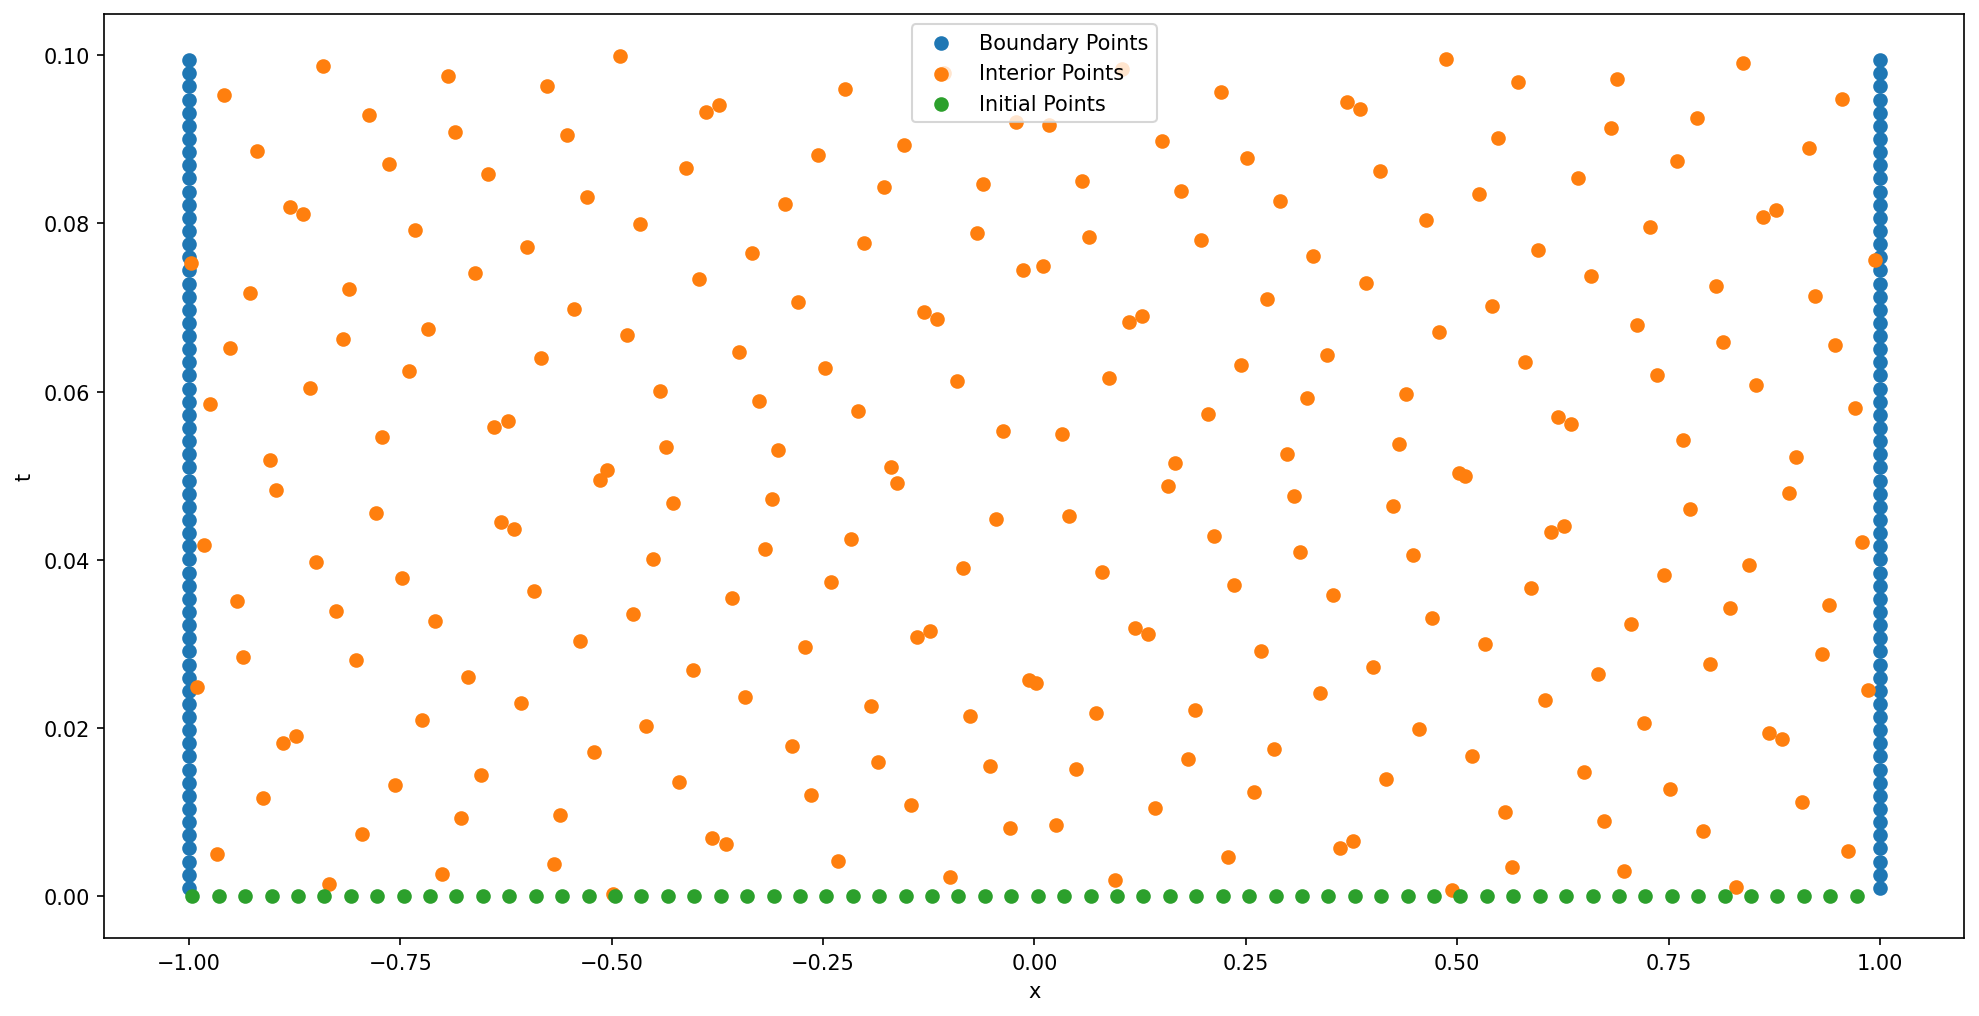

In [15]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [16]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

################################  0  ################################
Final Loss:  0.09695130586624146


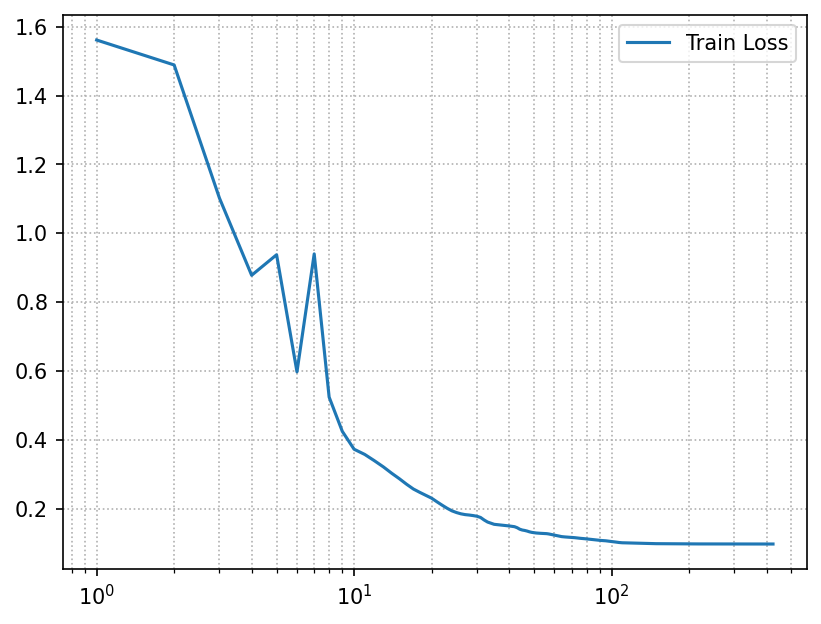

In [17]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

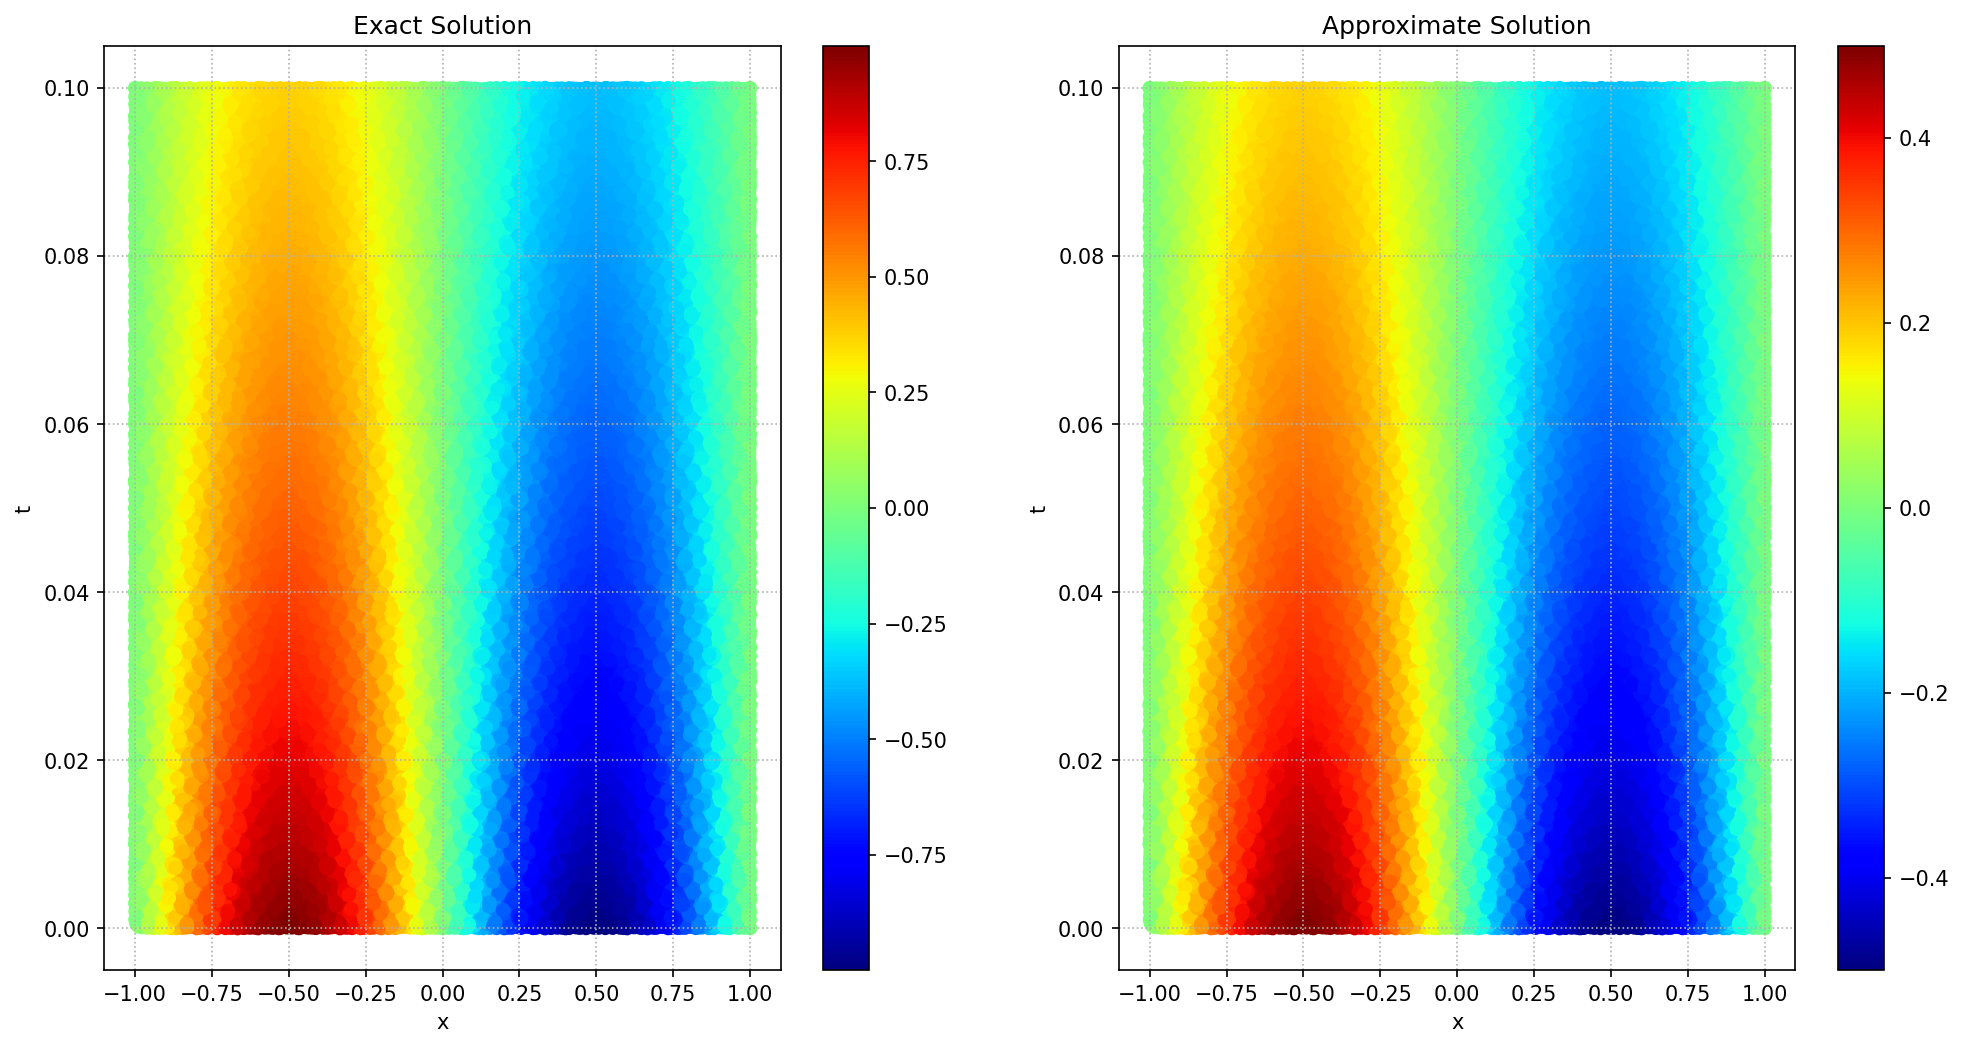

L2 Relative Error Norm:  49.968814849853516 %


In [18]:
pinn.plotting()